In [1]:
import eelbrain
import eelbrain.datasets._alice
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import resample

In [2]:
DATA_ROOT = eelbrain.datasets._alice.get_alice_path()

# Define some paths that will be used throughout
STIMULUS_DIR = DATA_ROOT / 'stimuli'
EEG_DIR = DATA_ROOT / 'eeg'

# Load one subject's raw EEG file
SUBJECT = 'S18'
LOW_FREQUENCY = 0.5
HIGH_FREQUENCY = 20

In [3]:
raw = mne.io.read_raw(EEG_DIR / SUBJECT / f'{SUBJECT}_alice-raw.fif', preload=True)

# Filter the raw data to the desired band
raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)

# Interpolate bad channels
# This is not structly necessary for a single subject.
# However, when processing multiple subjects, it will allow comparing results across all sensors.
raw.interpolate_bads()

# Load the events embedded in the raw file as eelbrain.Dataset, a type of object that represents a data-table
events = eelbrain.load.mne.events(raw)

# Display the events table:
events

#,i_start,trigger,event
0,6495,1,1
1,35304,5,2
2,65752,6,3
3,97408,7,4
4,132429,8,5
5,165593,9,6
6,197508,10,7
7,228988,11,8
8,257678,12,9
9,286316,2,10


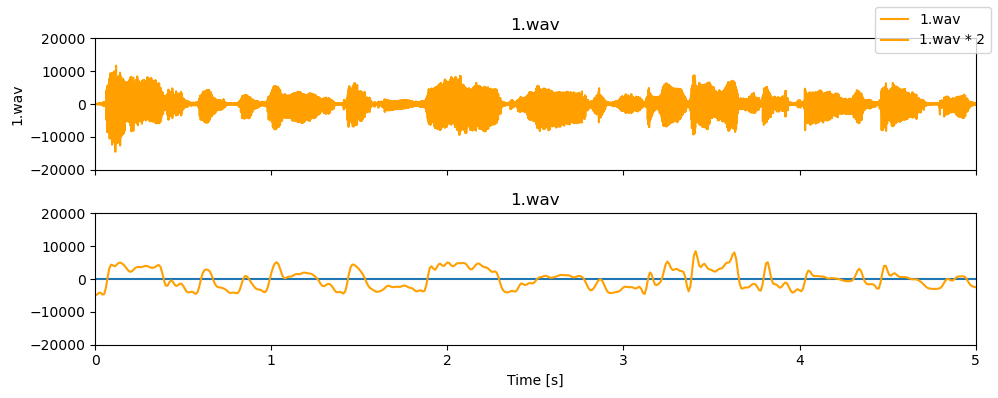

In [4]:
# Load the sound file corresponding to trigger 1
wav = eelbrain.load.wav(STIMULUS_DIR / f'1.wav')

# Compute the acoustic envelope
envelope = wav.envelope()

# Filter the envelope with the same parameters as the EEG data
envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
envelope = eelbrain.resample(envelope, 100)

# Visualize the first 5 seconds
p = eelbrain.plot.UTS([wav, envelope * 2], axh=2, w=10, columns=1, xlim=5)

# Add y=0 as reference
p.add_hline(0, zorder=0)

In [5]:
envelopes = []
for stimulus_id in events['event']:
    wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav')
    envelope = wav.envelope()
    envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
    envelope = eelbrain.resample(envelope, 100)
    envelopes.append(envelope)

# Add the envelopes to the events table
events['envelope'] = envelopes

# Add a second predictor corresponding to acoustic onsets
events['onsets'] = [envelope.diff('time').clip(0) for envelope in envelopes]
events

#,i_start,trigger,event,envelope,onsets
0,6495,1,1,<NDVar '1.wa...,<NDVar '1.wa...
1,35304,5,2,<NDVar '2.wa...,<NDVar '2.wa...
2,65752,6,3,<NDVar '3.wa...,<NDVar '3.wa...
3,97408,7,4,<NDVar '4.wa...,<NDVar '4.wa...
4,132429,8,5,<NDVar '5.wa...,<NDVar '5.wa...
5,165593,9,6,<NDVar '6.wa...,<NDVar '6.wa...
6,197508,10,7,<NDVar '7.wa...,<NDVar '7.wa...
7,228988,11,8,<NDVar '8.wa...,<NDVar '8.wa...
8,257678,12,9,<NDVar '9.wa...,<NDVar '9.wa...
9,286316,2,10,<NDVar '10.w...,<NDVar '10.w...


In [6]:
# Extract the stimulus duration (in seconds) from the envelopes
events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')
events

#,i_start,trigger,event,envelope,onsets,duration,eeg
0,6495,1,1,<NDVar '1.wa...,<NDVar '1.wa...,57.54,<NDVar: 61 s...
1,35304,5,2,<NDVar '2.wa...,<NDVar '2.wa...,60.85,<NDVar: 61 s...
2,65752,6,3,<NDVar '3.wa...,<NDVar '3.wa...,63.26,<NDVar: 61 s...
3,97408,7,4,<NDVar '4.wa...,<NDVar '4.wa...,69.99,<NDVar: 61 s...
4,132429,8,5,<NDVar '5.wa...,<NDVar '5.wa...,66.27,<NDVar: 61 s...
5,165593,9,6,<NDVar '6.wa...,<NDVar '6.wa...,63.78,<NDVar: 61 s...
6,197508,10,7,<NDVar '7.wa...,<NDVar '7.wa...,62.9,<NDVar: 61 s...
7,228988,11,8,<NDVar '8.wa...,<NDVar '8.wa...,57.31,<NDVar: 61 s...
8,257678,12,9,<NDVar '9.wa...,<NDVar '9.wa...,57.23,<NDVar: 61 s...
9,286316,2,10,<NDVar '10.w...,<NDVar '10.w...,61.27,<NDVar: 61 s...


In [7]:
# Use a larger delta to speed up training
decoder = eelbrain.boosting('envelope', 'eeg', 0.175, 0.225, data=events[:11], partitions=5, delta=0.05, test=True)

# Normalize the EEG
eeg_11 = events[11, 'eeg'] / decoder.x_scale

# Predict the envelope by convolving the decoder with the EEG
y_pred = eelbrain.convolve(decoder.h, eeg_11, name='predicted envelope')

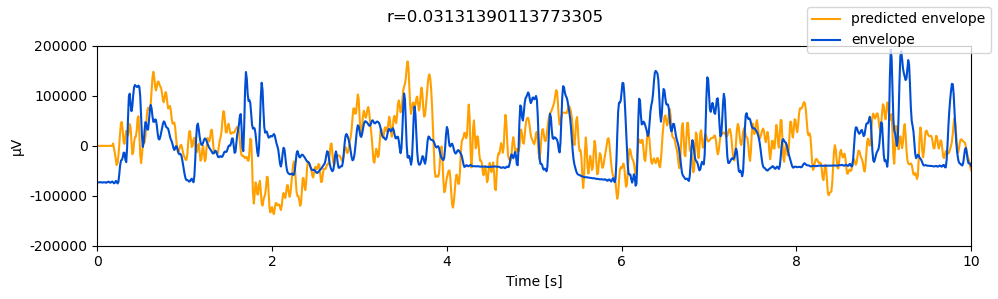

In [8]:
y = events[11, 'envelope']
y = y - decoder.y_mean
y /= decoder.y_scale / y_pred.std()
y.name = 'envelope'

r = eelbrain.correlation_coefficient(y, y_pred)
p = eelbrain.plot.UTS([[y_pred, y]], w=10, h=3, xlim=10, title=f"{r=}")

In [9]:
residuals = decoder.l2_residual / decoder.l2_total
explained_variance = 1 - residuals
print(explained_variance)

# standard_error = np.std(residuals, ddof=1)
# print(f"Standard Error: {standard_error}")

mean_l1_residual = decoder.l2_residual / len(y)  # Normalize by total samples
print(mean_l1_residual)

# corr = np.corrcoef(y.x.flatten(), y_pred.x.flatten())[0, 1]  # Pearson correlation
# print(f"Prediction correlation: {corr:.4f}")
# print(decoder.error)

0.0025714248013378738
14.364202876163569


In [10]:
def create_decoder(tstart, tstop, events):
    # Use a larger delta to speed up training
    decoder = eelbrain.boosting('envelope', 'eeg', tstart, tstop, data=events[:11], partitions=5, delta=0.05, test=True)
    
    # Normalize the EEG
    eeg_11 = events[11, 'eeg'] / decoder.x_scale
    
    # Predict the envelope by convolving the decoder with the EEG
    y_pred = eelbrain.convolve(decoder.h, eeg_11, name='predicted envelope')
    
    y = events[11, 'envelope']
    y = y - decoder.y_mean
    y /= decoder.y_scale / y_pred.std()
    y.name = 'envelope'

    r = eelbrain.correlation_coefficient(y, y_pred)

    residuals = decoder.l2_residual / decoder.l2_total
    explained_variance = 1 - residuals

    standard_error = decoder.l2_residual / len(y)  # Normalize by total samples

    return r, explained_variance, standard_error

[(-0.05, 0.0), (0.0, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, 0.25)]
The standard error in microV between -0.05 and 0.0 is 14.20751950447652
The standard error in microV between 0.0 and 0.05 is 14.252968193125177
The standard error in microV between 0.05 and 0.1 is 14.30509067443887
The standard error in microV between 0.1 and 0.15 is 14.325167968201738
The standard error in microV between 0.15 and 0.2 is 14.35661341221791
The standard error in microV between 0.2 and 0.25 is 14.390998460853167


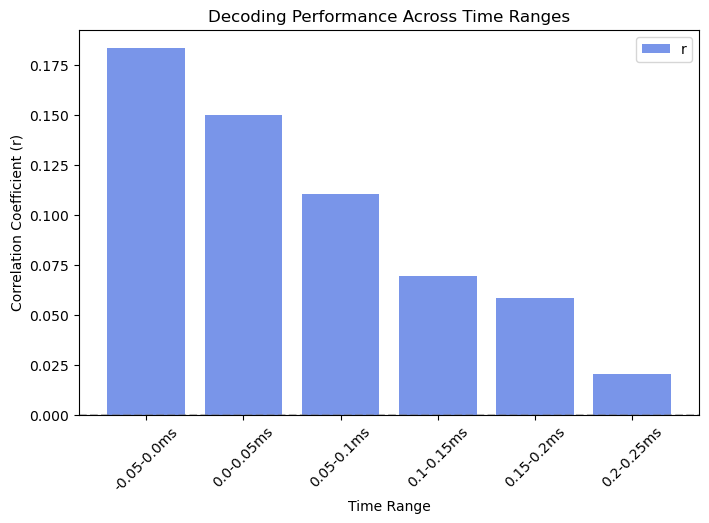

In [11]:
# Question 1

latencies = [(round(x, 2), round(x + 0.05, 2)) for x in np.arange(-0.05, 0.25, 0.05)]
print(latencies)

r_values = []

for latency in latencies:
    performance = create_decoder(latency[0], latency[1], events)
    r_values.append(performance[0])
    print(f"The standard error in microV between {latency[0]} and {latency[1]} is {performance[2]}")

# Convert tuple ranges to string labels for plotting
range_labels = [f"{start}-{end}ms" for start, end in latencies]

# X-axis positions
x_pos = np.arange(len(latencies))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars with error bars
ax.bar(x_pos, r_values, capsize=5, color='royalblue', alpha=0.7, label="r")

# Add labels and title
ax.set_xticks(x_pos)
ax.set_xticklabels(range_labels, rotation=45)  # Rotate for better visibility
ax.set_ylabel("Correlation Coefficient (r)")
ax.set_xlabel("Time Range")
ax.set_title("Decoding Performance Across Time Ranges")
ax.axhline(0, color='gray', linestyle='dashed', alpha=0.5)  # Reference line at r = 0

# Show legend and plot
plt.legend()
plt.show()


C:\Users\Tyler Lee\AppData\Local\Temp\ipykernel_9912\3318616015.py:19: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()
C:\Users\Tyler Lee\AppData\Local\Temp\ipykernel_9912\3318616015.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  y_n /= decoder.y_scale / y_pred_n.std()
C:\Users\Tyler Lee\AppData\Local\Temp\ipykernel_9912\3318616015.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  y_n_1 /= decoder.y_scale / y_pred_n_1.std()


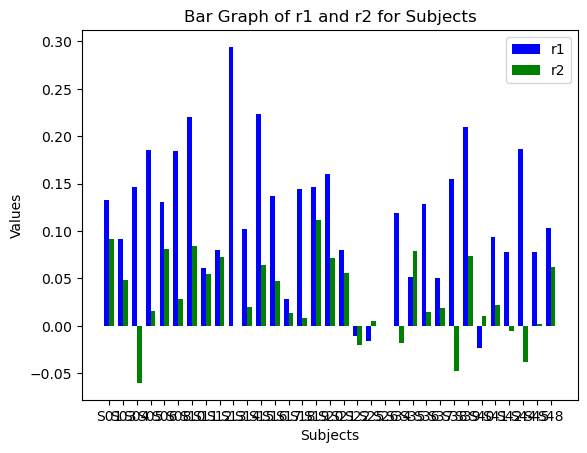

In [17]:
# Question 2

# Based on my observations above, excluding my baseline latency, 0 - 0.5 ms is the latency that has the highest correlation coefficient
# so that will be my optimal

SUBJECTS = [name for name in os.listdir(EEG_DIR) if os.path.isdir(os.path.join(EEG_DIR, name))]
r1 = []
r2 = []

def compare_pearson_correlation(subject_name):
    raw = mne.io.read_raw(EEG_DIR / f'{subject_name}' / f'{subject_name}_alice-raw.fif', preload=True)

    # Filter the raw data to the desired band
    raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)
    
    # Interpolate bad channels
    # This is not structly necessary for a single subject.
    # However, when processing multiple subjects, it will allow comparing results across all sensors.
    raw.interpolate_bads()
    
    # Load the events embedded in the raw file as eelbrain.Dataset, a type of object that represents a data-table
    events = eelbrain.load.mne.events(raw)

    envelopes = []
    for stimulus_id in events['event']:
        wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav')
        envelope = wav.envelope()
        envelope = eelbrain.filter_data(envelope, LOW_FREQUENCY, HIGH_FREQUENCY, pad='reflect')
        envelope = eelbrain.resample(envelope, 100)
        envelopes.append(envelope)
    
    # Add the envelopes to the events table
    events['envelope'] = envelopes
    
    # Add a second predictor corresponding to acoustic onsets
    events['onsets'] = [envelope.diff('time').clip(0) for envelope in envelopes]

    # Extract the stimulus duration (in seconds) from the envelopes
    events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']])
    events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto')

    # Use a larger delta to speed up training
    decoder = eelbrain.boosting('envelope', 'eeg', 0, 0.05, data=events[:-2], partitions=5, delta=0.05, test=True)
    
    # Normalize the EEG
    eeg_n = events[-1, 'eeg'] / decoder.x_scale
    eeg_n_1 = events[-2, 'eeg'] / decoder.x_scale
    
    # Predict the envelope by convolving the decoder with the EEG
    y_pred_n = eelbrain.convolve(decoder.h, eeg_n, name='predicted envelope n')
    y_pred_n_1 = eelbrain.convolve(decoder.h, eeg_n_1, name='predicted envelope n - 1')

    y_n = events[-1, 'envelope']
    y_n = y_n - decoder.y_mean
    y_n /= decoder.y_scale / y_pred_n.std()
    y_n.name = 'envelope'

    y_n_1 = events[-2, 'envelope']
    y_n_1 = y_n_1 - decoder.y_mean
    y_n_1 /= decoder.y_scale / y_pred_n_1.std()
    y_n_1.name = 'envelope'

    r1 = eelbrain.correlation_coefficient(y_n, y_pred_n)

    resample_len = len(y_pred_n)
    # y_n_1 = resample(y_n_1, resample_len)
    # r2 = eelbrain.correlation_coefficient(y_n_1, y_pred_n)
    y_n_1_resampled = resample(y_n_1, resample_len)

    # Recreate time dimension (e.g., assuming uniform time sampling)
    time = eelbrain.UTS(0, y_n_1.time.tstep, resample_len)  # Replace with actual `tstep`
    y_n_1_ndvar = eelbrain.NDVar(y_n_1_resampled, dims=(time,), name='resampled envelope')
    r2 = eelbrain.correlation_coefficient(y_n_1_ndvar, y_pred_n)

    return r1, r2

# Actual code starts here

for subject in SUBJECTS:
    r_values = compare_pearson_correlation(subject)
    r1.append(r_values[0])
    r2.append(r_values[1])

# Bar settings
x = np.arange(len(SUBJECTS))  # Positions of subjects on x-axis
width = 0.35  # Width of the bars

# Plot bars
plt.bar(x - width/2, r1, width, label='r1', color='blue')
plt.bar(x + width/2, r2, width, label='r2', color='green')

# Add labels and title
plt.xlabel('Subjects')
plt.ylabel('Values')
plt.title('Bar Graph of r1 and r2 for Subjects')
plt.xticks(x, SUBJECTS)  # Set the x-axis labels to subjects
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Based on the bar graph above plotting r1 (reconstructed envelope of trial n correlated with envelope of trial n) and
# r2 (reconstructed envelope of trial n correlated with envelope of trial n-1), it appears that the greater the length
# of the test data, the greater the performance of the decoder becomes.